In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from scipy.stats import ttest_rel

## 1. Read the file & prepare the dataframe

In [29]:
# Load the datafrane
data = pd.read_excel('/Users/federico.carrara/Documents/Projects/artherapy/ExplorARTPD_Database_for_Analysis_May_2024.xlsx')

Delete subject with too many missing data

In [30]:
# Remove subjects with too many missing values
missing_vals_per_id = data.isnull().sum(axis=1)
id_mask = missing_vals_per_id <= len(data.columns) * 0.5
data = data[id_mask]
data.shape

(39, 125)

In [31]:
n_subj = len(data)
print(f"Number of valid subjects: {n_subj}")

Number of valid subjects: 39


Delete meaningless variables (Benton Fail Resp)

In [32]:
data.drop(
    columns=[
        "Benton Fail Resp BL",
        "Benton Fail Resp FU"
    ],
    inplace=True)
data.shape

(39, 123)

In [33]:
# Problem with "LEDD" invariata
mask = (data["LEDD FU"] == "invariata") | (data["LEDD FU"] == "invariata?")
data.loc[mask, "LEDD FU"] = data.loc[mask, "LEDD BL"].copy()
data["LEDD FU"] = data["LEDD FU"].astype(float)

In [34]:
# Create two sample pandas Series with boolean values
series1 = pd.Series([True, False, True, False])
series2 = pd.Series([False, True, True, False])

# Perform the logical OR operation
result_series = series1 | series2

print(result_series)

0     True
1     True
2     True
3    False
dtype: bool


In [35]:
# Fix column names
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")
data = data.rename(columns={"EDUCATION_(years)": "EDUCATION", "corrected_LEDD": "corrected_LEDD_BL"})
data.columns = data.columns.str.lower()
data.columns

Index(['subject_id', 'group', 'age', 'gender', 'education', 'hand_dominance',
       'age_at_pd_onset', 'pd_duration', 'side', 'ledd_bl',
       ...
       'navon_local_fu', 'navon_global_fu', 'navon_errors_fu',
       'visual_search_total_fu', 'simple_reaction_time_fu', 'benton_corr_fu',
       'benton_periph_err_fu', 'benton_major_rot_fu', 'benton_major_dist_fu',
       'rey_copy_corr_fu'],
      dtype='object', length=123)

Split the data in BL and FU

In [36]:
# Columns for general features
general_features_cols = [
    'subject_id', 'group', 'age',
    'gender', 'education', 'hand_dominance',
    'age_at_pd_onset', 'pd_duration', 'side'
]

# Columns for baseline (BL) variables
bl_cols = [col for col in data.columns if 'bl' in col]
bl_cols = sorted(bl_cols)

# Columns for follow-up (FU) variables
fu_cols = [col for col in data.columns if 'fu' in col]
fu_cols = sorted(fu_cols)

print("\nGeneral Features Columns:", general_features_cols)
print("Baseline Columns:", bl_cols)
print("Follow-up Columns:", fu_cols)

# Sub-dataset for baseline (BL) variables
data_BL = deepcopy(data[general_features_cols + bl_cols])

# Sub-dataset for follow-up (FU) variables
data_FU = deepcopy(data[general_features_cols + fu_cols])


General Features Columns: ['subject_id', 'group', 'age', 'gender', 'education', 'hand_dominance', 'age_at_pd_onset', 'pd_duration', 'side']
Baseline Columns: ['apathy_bl', 'bai_bl', 'balance_confidence_%_bl', 'balance_confidence_total_bl', 'bdi_bl', 'benton_corr_bl', 'benton_major_dist_bl', 'benton_major_rot_bl', 'benton_periph_err_bl', 'corrected_ledd_bl', 'date_bl', 'h&y_bl', 'ledd_bl', 'mfis_cognitive_bl', 'mfis_phys_bl', 'mfis_psychosocial_bl', 'mfis_tot_bl', 'moca_tot_bl', 'moca_visual_bl', 'navon_errors_bl', 'navon_global_bl', 'navon_local_bl', 'navon_none_bl', 'pdq39__adl_bl', 'pdq39_bodily_discom_bl', 'pdq39_cognitive_bl', 'pdq39_communication_bl', 'pdq39_emotions_bl', 'pdq39_mobility_bl', 'pdq39_social_support_bl', 'pdq39_stigma_bl', 'pdq39_tot_bl', 'pegboard_dominant_bl', 'pegboard_non_dominant_bl', 'perceived_stress_scale_bl', 'promis_adl_bl', 'promis_emotions_bl', 'promis_meds_bl', 'promis_social_bl', 'promis_symptoms_bl', 'rey_copy_corr_bl', 'saps_major_hall_bl', 'saps_mi

Drop features for which the number of missing values is more than 1/2

In [37]:
# # BL
# for var in data_BL.columns:
#     n_missing = data_BL.loc[:, var].isnull().sum()
#     if (n_missing > len(data_BL) / 2):
#         print(f"Drpping column {var} with {n_missing} missing values.")
#         # data_BL.drop(columns=var, axis=1, inplace=True)
# print(data_BL.shape)

# # FU
# for var in data_FU.columns:
#     n_missing = data_FU.loc[:, var].isnull().sum()
#     if (n_missing > len(data_BL) / 2):
#         print(f"Drpping column {var} with {n_missing} missing values.")
#         # data_FU.drop(columns=var, axis=1, inplace=True)
# print(data_FU.shape)

Drop features that are characterized as "*tot*" as they are just the some of features of the same category.

In [38]:
# Check that we have the same number of missing values for each pair of BL and FU variables
for bl_var, fu_var in zip(bl_cols, fu_cols):
    n_missing_bl = data_BL[bl_var].isnull().sum()
    n_missing_fu = data_FU[fu_var].isnull().sum()
    if n_missing_bl != n_missing_fu:
        print(f"BL: {bl_var} - Missing values: {n_missing_bl}")
        print(f"FU: {fu_var} - Missing values: {n_missing_fu}")

BL: apathy_bl - Missing values: 27
FU: apathy_fu - Missing values: 25
BL: balance_confidence_%_bl - Missing values: 28
FU: balance_confidence_%_fu - Missing values: 27
BL: balance_confidence_total_bl - Missing values: 28
FU: balance_confidence_total_fu - Missing values: 27
BL: bdi_bl - Missing values: 0
FU: bdi_fu - Missing values: 2
BL: benton_corr_bl - Missing values: 3
FU: benton_corr_fu - Missing values: 5
BL: benton_major_dist_bl - Missing values: 3
FU: benton_major_dist_fu - Missing values: 6
BL: benton_major_rot_bl - Missing values: 3
FU: benton_major_rot_fu - Missing values: 6
BL: benton_periph_err_bl - Missing values: 3
FU: benton_periph_err_fu - Missing values: 6
BL: moca_tot_bl - Missing values: 0
FU: moca_tot_fu - Missing values: 1
BL: moca_visual_bl - Missing values: 0
FU: moca_visual_fu - Missing values: 1
BL: navon_errors_bl - Missing values: 13
FU: navon_errors_fu - Missing values: 12
BL: navon_global_bl - Missing values: 14
FU: navon_global_fu - Missing values: 12
BL: 

We have different missing values for each feature....

In [39]:
print(data_BL.shape)
to_drop = [col for col in data_BL.columns.tolist() if "tot" in col and not "total" in col]
data_BL = data_BL.drop(columns=to_drop)
print(to_drop)
print(data_BL.shape)

print(data_FU.shape)
to_drop = [col for col in data_FU.columns.tolist() if "tot" in col and not "total" in col]
data_FU = data_FU.drop(columns=to_drop)
print(to_drop)
print(data_FU.shape)

(39, 65)
['mfis_tot_bl', 'moca_tot_bl', 'pdq39_tot_bl', 'saps_tot_bl', 'updrs_tot_bl']
(39, 60)
(39, 65)
['mfis_tot_fu', 'moca_tot_fu', 'pdq39_tot_fu', 'saps_tot_fu', 'updrs_tot_fu']
(39, 60)


### 1. Do t-test for each variable

In [57]:
def t_test_for_pairs(df_bl, df_fu):
    """
    Perform a t-test for each pair of baseline (BL) and follow-up (FU) variables.
    """
    t_test_results = {}

    # Iterate over the columns
    for bl_col in df_bl.columns:
        if '_bl' in bl_col and bl_col != "date_bl":
            # Extract the follow-up column name
            fu_col = bl_col.replace('_bl', '_fu')
            
            assert df_bl["subject_id"].equals(df_fu["subject_id"]), "Subject IDs are not the same."
            
            # Check if they have the same number of missing vals
            n_missing_bl = df_bl[bl_col].isnull().sum()
            n_missing_fu = df_fu[fu_col].isnull().sum()
            n_missing = max(n_missing_bl, n_missing_fu)
            print(f'Column: {bl_col} - Missing values: {n_missing}')
            # who_is_missing_most = "BL" if n_missing_bl >= n_missing_fu else "FU"
            
            # # Get common subejct ids
            # if who_is_missing_most == "BL":
            #     common_ids = df_bl["subject_id"][~df_bl[bl_col].isnull()] 
            # else:
            #     common_ids = df_fu["subject_id"][~df_fu[fu_col].isnull()]
            
            # # Filter the data for the pair of BL and FU variables
            # id_mask = df_bl["subject_id"].isin(common_ids) 
            # data_bl = df_bl[bl_col][id_mask].to_numpy()
            # data_fu = df_fu[fu_col][id_mask].to_numpy()
            
            # Perform t-test for paired samples
            data_bl = df_bl[bl_col].to_numpy()
            data_fu = df_fu[fu_col].to_numpy()
            try:
                _, p_value = ttest_rel(a=data_bl, b=data_fu, nan_policy='omit')
            except:
                print(f"bl_col: {bl_col}")
                
            if np.isnan(p_value):
                print(f"data: {data_bl, data_fu}")
            
            # Save the t-test results
            t_test_results[bl_col.replace("_bl", "")] = {'p_value': p_value}

    return t_test_results

In [58]:
t_test_dict = t_test_for_pairs(data_BL, data_FU)

Column: apathy_bl - Missing values: 27
Column: bai_bl - Missing values: 17
Column: balance_confidence_%_bl - Missing values: 28
Column: balance_confidence_total_bl - Missing values: 28
Column: bdi_bl - Missing values: 2
Column: benton_corr_bl - Missing values: 5
Column: benton_major_dist_bl - Missing values: 6
Column: benton_major_rot_bl - Missing values: 6
Column: benton_periph_err_bl - Missing values: 6
Column: corrected_ledd_bl - Missing values: 0
Column: h&y_bl - Missing values: 0
Column: ledd_bl - Missing values: 0
Column: mfis_cognitive_bl - Missing values: 7
Column: mfis_phys_bl - Missing values: 8
Column: mfis_psychosocial_bl - Missing values: 7
Column: moca_visual_bl - Missing values: 1
Column: navon_errors_bl - Missing values: 13
Column: navon_global_bl - Missing values: 14
Column: navon_local_bl - Missing values: 13
Column: navon_none_bl - Missing values: 13
Column: pdq39__adl_bl - Missing values: 1
Column: pdq39_bodily_discom_bl - Missing values: 1
Column: pdq39_cognitive_b

In [60]:
def get_significant_pvalues(t_test_dict, alpha=0.05):
    """
    Get the significant p-values from the t-test dictionary.
    """
    significant_pvalues = {}
    for key, value in t_test_dict.items():
        if value['p_value'] < alpha:
            significant_pvalues[key] = value['p_value']
    return significant_pvalues

print(get_significant_pvalues(t_test_dict))

{'balance_confidence_%': 0.01826354201763754, 'balance_confidence_total': 0.01826354201763754, 'bdi': 0.01747445748981843, 'navon_local': 0.036022910326211584, 'pdq39_emotions': 0.03647178766290469, 'pegboard_non_dominant': 0.0388168730366192, 'tug_2': 0.018623930042427683, 'tug_cost': 0.013094071755484032, 'updrs_i': 0.005709708965728694, 'updrs_iii': 4.779534145320537e-05}


## 2. Fill the missing values using KNN imputation

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, MissingIndicator, IterativeImputer

indicator = MissingIndicator(missing_values=np.nan, features="all")
imputer = KNNImputer(n_neighbors=3, weights='uniform')
# imputer = IterativeImputer(max_iter=50, random_state=1234)

# Get masks of imputed values
missing_mask_BL = indicator.fit_transform(data_BL)
missing_mask_FU = indicator.fit_transform(data_FU)

# Perform imputation on the datasets
filled_BL = imputer.fit_transform(data_BL)
filled_FU = imputer.fit_transform(data_FU)

In [ ]:
data_BL = pd.DataFrame(data = filled_BL,
                       columns = data_BL.columns,
                       index = data_BL.index)

data_FU = pd.DataFrame(data = filled_FU,
                       columns = data_FU.columns,
                       index = data_FU.index)

In [ ]:
# imputer = IterativeImputer(max_iter=50)
# filled_BL2 = imputer.fit_transform(data_BL)
# data_BL2 = pd.DataFrame(data = filled_BL2,
#                        columns = data_BL.columns,
#                        index = data_BL.index)

In [ ]:
# # Plot distributions of imputed features
# # e.g. Rey Copy
# plt.figure(figsize=(9,3))
# plt.subplot(131)
# n, bins, patches = plt.hist(x=data_BL1["Rey Copy Corr BL"], bins="auto", density=True, facecolor="C0")

# plt.subplot(132)
# n, bins, patches = plt.hist(x=data_BL2["Rey Copy Corr BL"], bins="auto", density=True, facecolor="C1")

# plt.subplot(133)
# n, bins, patches = plt.hist(x=data_BL["Rey Copy Corr BL"], bins="auto", density=True, facecolor="C2")

In [ ]:
# dicky = {}
# dicky["original"] = data_BL["Rey Copy Corr BL"]
# dicky["KNN"] = data_BL1["Rey Copy Corr BL"]
# dicky["Iterative"] = data_BL2["Rey Copy Corr BL"]
# dicky = pd.DataFrame(dicky)
# dicky

Adjust Data Types (e.g. Round numbers to integers)

All features are *integers* except for:
- TUG features;
- Navon (except *Navon Errors*);
- Pegboard;
- Visual Search

In [ ]:
# BL
for col in data_BL.columns:
  if not ("TUG" in col or "Pegboard" in col or "Navon" in col or "Visual Search" in col):
    data_BL = data_BL.astype({col : "int32"})

# FU
for col in data_FU.columns:
  if not ("TUG" in col or "Pegboard" in col or "Navon" in col or "Visual Search" in col):
    data_FU = data_FU.astype({col : "int32"})

# Convert also Navon Errors to int
data_BL = data_BL.astype({"Navon Errors BL" : "int32"})
data_FU = data_FU.astype({"Navon Errors FU" : "int32"})

In [ ]:
data_BL.head(10)

,H&Y BL,MoCa Visual BL,BDI BL,UPDRS_I BL,UPDRS_II BL,UPDRS_III BL,UPDRS_IV BL,MFIS Phys BL,MFIS Cognitive BL,MFIS PsychoSocial BL,...,Navon Local BL,Navon Global BL,Navon Errors BL,Visual Search Total BL,Simple Reaction Time BL,Benton Corr BL,Benton Periph Err BL,Benton Major Rot BL,Benton Major Dist BL,Rey Copy Corr BL
SUBJECT ID,,,,,,,,,,,,,,,,,,,,,
1,2,5,4,11,4,36,0,11,7,1,...,1132.773333,1241.976667,0,1252.939394,417,16,0,0,0,34
2,2,5,14,17,13,41,8,13,12,0,...,944.260000,1041.790000,1,1170.673333,406,14,1,0,0,31
4,3,5,2,14,13,42,9,11,8,1,...,1374.440000,1120.436667,4,1270.152958,407,14,2,0,0,30
5,3,4,7,26,19,33,9,19,9,4,...,864.682051,1127.583333,4,1260.560000,439,8,5,1,2,5
6,2,4,5,1,2,35,3,10,9,1,...,1070.026667,1186.110000,2,1324.409949,405,12,0,2,2,35
7,2,4,8,20,16,29,12,19,6,3,...,967.883333,1031.090000,3,1236.174872,421,15,1,0,0,31
8,2,4,4,5,9,46,0,7,6,1,...,1310.113333,1137.353333,1,1183.163513,411,11,3,1,1,24
14,2,4,7,16,12,26,0,17,17,2,...,1170.400000,1137.833333,5,1358.416667,447,15,0,1,0,18
15,2,3,20,19,22,49,7,4,1,2,...,1268.916667,1008.100000,6,1361.076923,407,4,10,1,1,19


## 3. Prepare Dataset
Two analysis will be performed:


1.   Comparison BL vs FU -> differences in the features
2.   Prediction of *UPDRSIII* variation based on BL features

N.B. For the first analysis we don't need further data preprocessing.

On the contrary for the second analysis we have to compute explicitly the *delta_UPDRSIII* value.



In [ ]:
# Prepare data for prediction task
data_pred = data_BL

# Remove non UPDRSIII columns
for col in data_pred.columns:
  if "UPDRS" in col and not col=="UPDRS_III BL":
    data_pred.drop(columns=col, inplace=True)

# Compute delta_UPDRSIII column
data_pred["delta_UPDRSIII"] = data_FU["UPDRS_III FU"] - data_pred["UPDRS_III BL"] 
data_pred.drop(columns="UPDRS_III BL", inplace=True)

data_pred.shape

(35, 39)

Split predictors from the target variable, and transform the latter into categorical.

In [ ]:
# Features to explain UPDRSIII
X = data_pred.loc[:, data_pred.columns != "delta_UPDRSIII"].copy()
p = len(X.columns)
# Target variable
y = data_pred["delta_UPDRSIII"].copy()
y = y <= -6
# Transform into classification labels
y_cat = y.copy()
for i in range(len(y)):
  if y.iloc[i]:
    y_cat.iloc[i] = "BETTER"
  else:
    y_cat.iloc[i] = "WORSE|SAME"

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

Standardize Data

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

X_std = scaler.fit_transform(X)
X = pd.DataFrame(data=X_std, index=X.index, columns=X.columns)

# X_train_std = scaler.fit_transform(X_train)
# X_test_std = scaler.fit_transform(X_test)

# X_train = pd.DataFrame(data=X_train_std, index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(data=X_test_std, index=X_test.index, columns=X_test.columns)

#### 3.1. Transform the features with few unique values into *categorical*.

In [ ]:
# stds = X.std()
# means = X.mean()
# for i in range(len(stds)):
#   print(X.columns.tolist()[i], means[i], stds[i], stds[i]/means[i]*100)
# rel_stds = np.zeros(len(stds))
# for i in range(len(stds)):
#   rel_stds[i] = stds[i]/means[i]

In [ ]:
# # For each feature count the number of unique values
# feat_counts = []
# for i in range(X.shape[1]):
#   curr_count = X.iloc[:,i].value_counts()
#   feat_counts.append(curr_count)

# # for count in feat_counts:
# #   print(count.name, count.shape)

# # Identify potential categorical features
# counts_len = [count.shape[0] for count in feat_counts]
# maybe_categorical_idxs = np.where(np.asarray(counts_len) < 10)[0]
# maybe_categorical_names = [X.columns.tolist()[idx] for idx in maybe_categorical_idxs]
# maybe_categorical_names

In [ ]:
# maybe_categorical_names = [name for name in maybe_categorical_names if not "PDQ" in name]
# maybe_categorical_names

In [ ]:
# # Choose features to transform into categorical
# maybe_categorical_names = [name for name in maybe_categorical_names if not "PDQ" in name and not "MFIS" in name]
# maybe_categorical_names

# for i in range(len(feat_counts)):
#   if feat_counts[i].name in maybe_categorical_names:
#     print(feat_counts[i])

In [ ]:
# def into_categorical(var, threshold):
#   # We suppose that the variable is a column of a pd DataFrame (i.e. a pd Series)
#   var_bool = var <= threshold
#   # Transform into classification labels
#   var_cat = var_bool
#   for i in range(len(var)):
#     if var.iloc[i]:
#       var_cat.iloc[i] = "LOW"
#     else:
#       var_cat.iloc[i] = "HIGH"

#   return var_cat

In [ ]:
# thresholds = 
# thresholds_dict = dict(zip(maybe_categorical_names, thresholds))

# for name in maybe_categorical_names:
#   curr_var_cat = into_categorical(X[name], )


In [ ]:
# n_train = X_train.shape[0]
# n_test = X_test.shape[0]
# p = X_train.shape[1]

## 4. Feature Selection

### Analysis of Correlation between features

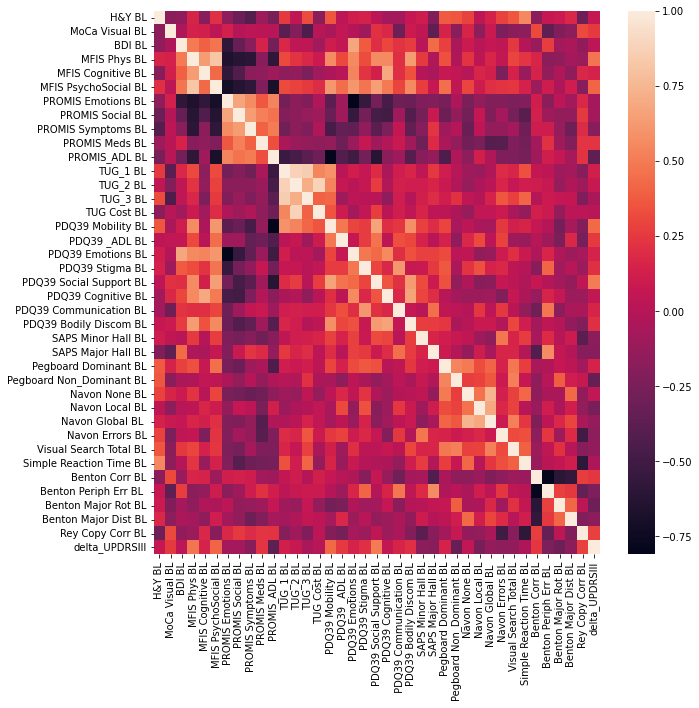

In [ ]:
X_complete = X.copy()
X_complete["delta_UPDRSIII"] = data_pred["delta_UPDRSIII"]
cor_mat = X_complete.corr()

plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, annot=False)

### 1. Filter-based methods
Apply common filter methods to remove features which are not correlatedby any means with the target.

#### 1.1. Pearson Correlation 
Compute the absolute correlation between each feature and the target. Features with higher correlation stands higher in the ranking.

In [ ]:
# # Calculate the correlation with y for each feature
# cor_list = np.zeros(len(X.columns))
# for i,col in enumerate(X.columns.tolist()):
#     cor = np.corrcoef(X[col], y)[0, 1]
#     cor = abs(cor)
#     cor_list[i] = cor

# # Store results in dictionaries
# sort_desc = (-cor_list).argsort()
# corr_scores = dict(zip(X.columns[sort_desc], cor_list[sort_desc]))
# corr_ranking = dict(zip(X.columns[sort_desc], np.arange(1,p+1)))

#### 1.2. ANOVA for Feature Selection
Perform an ANOVA test to see which variables are significant to explain the difference in the outcomes. 

In [ ]:
# from sklearn.feature_selection import f_classif

# f_scores, f_pvals = f_classif(X, y)

# # Store results in dictionaries
# sort = f_pvals.argsort()
# anova_scores = dict(zip(X.columns[sort], f_pvals[sort]))
# anova_ranking = dict(zip(X.columns[sort], np.arange(1,p+1)))

#### 1.3. Mutual Information
Compute the nonparametric Mutual Information to see which variables are significantly correlated to the target. 

In [ ]:
from sklearn.feature_selection import mutual_info_classif

np.random.RandomState(1234)

# Computation of mutual information is random
# Iterate the procedure for some times to get more  robust results
mi = np.zeros(len(X.columns))
for i in range(20):
  mi += mutual_info_classif(X, y, n_neighbors=5)

# Store results in dictionaries
sort_desc = (-mi).argsort()
mi_scores = dict(zip(X.columns[sort_desc], mi[sort_desc]))
mi_ranking = dict(zip(X.columns[sort_desc], np.arange(1,p+1)))

# Remove features which Mutual Information value is under a certain threshold
to_remove = []
for key in mi_scores.keys():
  if mi_scores[key] <= 0.2:
    to_remove.append(str(key))

print(len(to_remove))

21


**Permutation Test for Mutual Information**

**N.B.** Setting an appropriate threshold for the mutual information coefficient can be tricky. Therefore, we resort to a permutation test approach to assess whether a certain value for the MI coeff is significant or not.

Consider a feature X and the target y.
The hypothesis of the test are:

> **H0: (X indep. y) vs H1: (X related to y)**

Indeed:
- We consider as permutation schema, the *permutation of the samples*. In this way we destroy the relationship between X and y. 
- The *test statistic* is the value of MI(X,y) itself. Obviously it assumes greater value under H1.
- **N.B.** Intuitively, if the original value of MI(X,y) is not very far from the permutational distribution MI'(X',y'), then X and y are not significantly related. Viceversa for very distant values of MI(X,y).

In [ ]:
from progressbar import ProgressBar

def mutual_info_perm_test(X,y,B=1000,seed=1234):
  ''' X = pd.Dataframe object
      y = target values (pd.Series or array)
  '''

  # Set seed
  np.random.RandomState(seed)

  # Perform the test independently for each feature
  X = X.values
  y = y.values
  p_vals = np.zeros(X.shape[1])
  mi_avgs = np.zeros(X.shape[1])
  mi_stds = np.zeros(X.shape[1])
  
  # Iterate over the features
  pbar = ProgressBar()
  for i in pbar(range(X.shape[1])):
    # Select current feature
    curr_feat = X[:,i].reshape(-1,1)
    # Compute the original mutual info
    mi_0 = mutual_info_classif(curr_feat,y,n_neighbors=5)

    # Compute permutational distrib of mi
    mi_perm = np.zeros(B)
    for j in range(B):
      # Permute samples
      feat_perm = np.random.permutation(curr_feat)
      # Recompute mutual info
      mi_perm[j] = mutual_info_classif(feat_perm,y,n_neighbors=5)
    
    # Compute the p-value and avg and std of the mi distrib
    p_vals[i] = np.sum(mi_perm >= mi_0) / B
    mi_avgs[i] = np.mean(mi_perm)
    mi_stds[i] = np.std(mi_perm)

  return p_vals, mi_avgs, mi_stds

In [ ]:
mi_p_vals, mi_avgs, mi_stds = mutual_info_perm_test(X,y,B=1000) 

100% (38 of 38) |########################| Elapsed Time: 0:01:31 Time:  0:01:31


In [ ]:
mi_p_vals

array([1.   , 1.   , 0.262, 0.325, 0.114, 0.157, 1.   , 1.   , 0.186,
       1.   , 1.   , 1.   , 1.   , 1.   , 0.207, 1.   , 1.   , 0.296,
       1.   , 0.157, 1.   , 0.036, 1.   , 0.133, 1.   , 0.324, 1.   ,
       1.   , 1.   , 1.   , 0.289, 0.017, 1.   , 1.   , 1.   , 0.156,
       1.   , 0.295])

In [ ]:
mi_avgs

array([0.02763642, 0.02337382, 0.02303147, 0.02496936, 0.0257061 ,
       0.02638228, 0.02197455, 0.02297835, 0.02192557, 0.02419677,
       0.02420254, 0.02301303, 0.02502208, 0.0242081 , 0.02131198,
       0.02609221, 0.02578298, 0.02369064, 0.02605233, 0.02309022,
       0.02363764, 0.02913504, 0.02366314, 0.02364673, 0.02106123,
       0.02361046, 0.02279577, 0.02489936, 0.023036  , 0.02493247,
       0.0243613 , 0.02439184, 0.02336863, 0.02386924, 0.02563217,
       0.02600947, 0.023511  , 0.0224669 ])

In [ ]:
mi_stds

array([0.0461019 , 0.04047856, 0.03961781, 0.04449196, 0.04348491,
       0.04619025, 0.04021828, 0.04365884, 0.03827749, 0.04133261,
       0.04283215, 0.04193921, 0.0433352 , 0.0414855 , 0.03815781,
       0.04616762, 0.04201932, 0.04415988, 0.0435632 , 0.0387161 ,
       0.04297746, 0.04827572, 0.04137143, 0.04199733, 0.03660382,
       0.04098521, 0.0384687 , 0.04366419, 0.03998877, 0.04210021,
       0.04274003, 0.04034796, 0.03960598, 0.04407763, 0.04516087,
       0.04512566, 0.04230539, 0.0399148 ])

Given the small dataset employed and to be more cautious about our conclusions, we set the significance threshold for the p-value at 0.2.

In [ ]:
names = X.columns.tolist()
to_remove = [names[i] for i in np.where(mi_p_vals > 0.2)[0]]

In [ ]:
X_red = X.drop(columns=to_remove)
X_red.shape
X_red.columns.tolist()

['MFIS Cognitive BL',
 'MFIS PsychoSocial BL',
 'PROMIS Symptoms BL',
 'PDQ39 Social Support BL',
 ' PDQ39 Communication BL',
 'SAPS Minor Hall BL',
 'Visual Search Total BL',
 'Benton Major Rot BL']

Check Correlation btw features

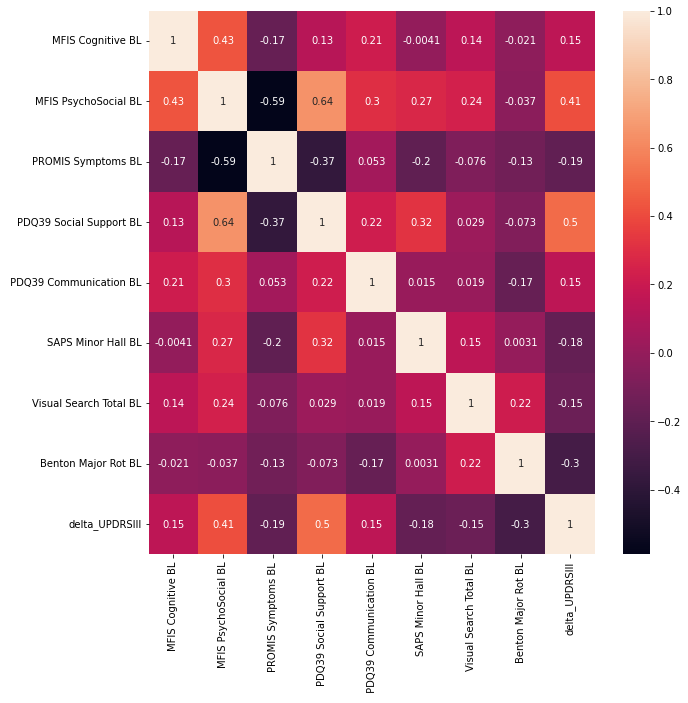

In [ ]:
X_complete = X_red.copy()
X_complete["delta_UPDRSIII"] = data_pred["delta_UPDRSIII"]
cor_mat = X_complete.corr()

plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, annot=True)

Plot the distribution of selected features by *delta_UPDRSIII* class. 

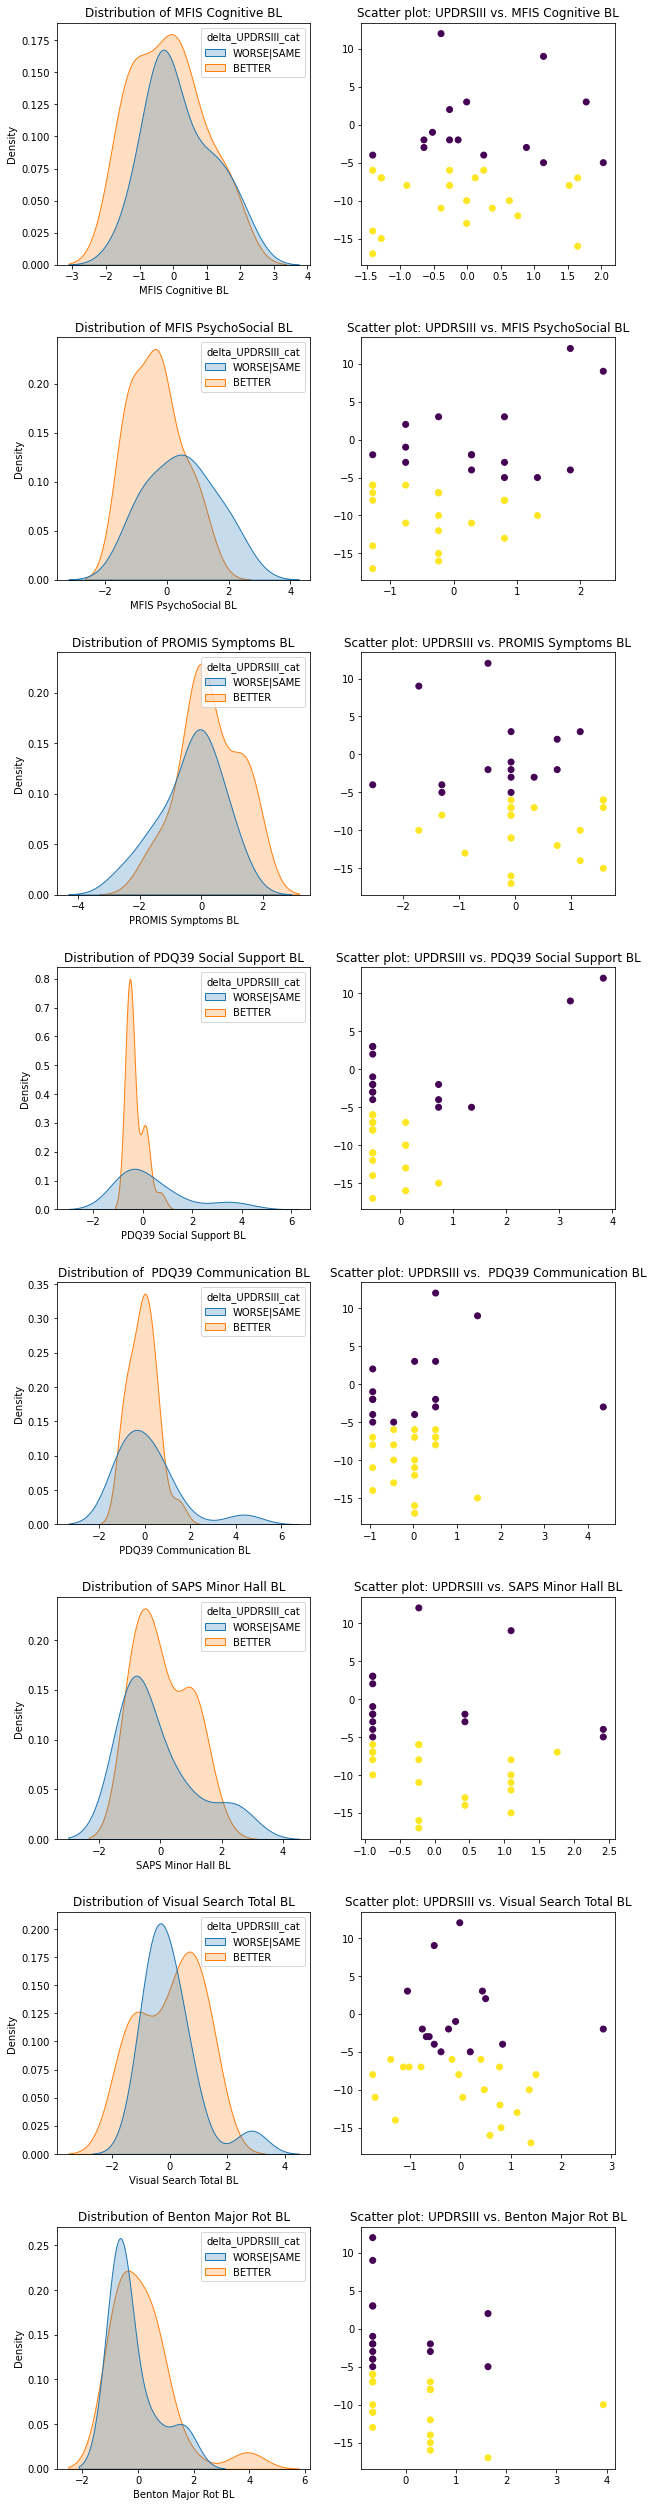

In [ ]:
X_complete["delta_UPDRSIII_cat"] = np.where(y == True, 'BETTER', 'WORSE|SAME')
y_cat = np.where(y == True, 1, 0)

fig, axs = plt.subplots(X_red.shape[1],2, figsize=(10,45))
fig.subplots_adjust(hspace=0.3)
for i in range(axs.shape[0]):
  curr_x = X_red.columns.tolist()[i]
  sns.kdeplot(ax=axs[i,0],
              data=X_complete, 
              x=curr_x, 
              hue="delta_UPDRSIII_cat", 
              fill=True)
  axs[i,0].set_title(" ".join(["Distribution of", curr_x]))
  axs[i,1].scatter(curr_x, "delta_UPDRSIII", data=X_complete,
                  c=y_cat)
  axs[i,1].set_title(" ".join(["Scatter plot: UPDRSIII vs.", curr_x]))



Comment: there is no evident discrepancy between the values in the 2 classes...

### 2. Dimensionality Reduction

#### 2.1. PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_red.shape[1])
pca.fit(X_red)
X_pca = pca.transform(X_red)

In [ ]:
np.cumsum(pca.explained_variance_ratio_ * 100)

array([ 31.23848054,  48.07569652,  62.18450503,  74.02127529,
        83.35919337,  91.33624625,  97.57088941, 100.        ])

N.B. 
- First 10 PC explain 85% of total variability.
- To get 95% of variability explained we would need 15 features.

Text(0, 0.5, 'Explained Variance')

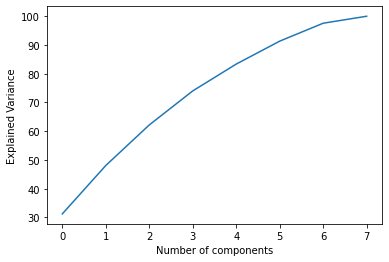

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")

Analyze the loading of the PCs

In [ ]:
col_names = ["PC" + str(i) for i in range(1, pca.n_components+1)]
loadings = pd.DataFrame(pca.components_.T, 
                        columns=col_names, 
                        index=X_red.columns)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
MFIS Cognitive BL,0.304699,0.151798,-0.568386,-0.249006,-0.430037,0.490892,0.156343,0.220678
MFIS PsychoSocial BL,0.583405,0.038281,-0.045710,-0.108858,-0.001166,-0.137469,0.030073,-0.790209
PROMIS Symptoms BL,-0.420448,0.258408,-0.207131,0.469202,0.028556,0.183858,0.573261,-0.360760
PDQ39 Social Support BL,0.477378,0.108617,0.314669,0.022927,0.247426,-0.119995,0.662699,0.382076
PDQ39 Communication BL,0.219987,0.521364,-0.306182,0.299770,0.567212,0.058666,-0.389746,0.138213
SAPS Minor Hall BL,0.282075,-0.185732,0.409177,0.590342,-0.224324,0.526703,-0.205540,-0.004857
Visual Search Total BL,0.184812,-0.414392,-0.467501,0.501974,-0.181971,-0.512864,0.019642,0.164499
Benton Major Rot BL,-0.003849,-0.647211,-0.230647,-0.122991,0.589802,0.384757,0.110994,-0.067491


Try to understand the meaning of the PCs

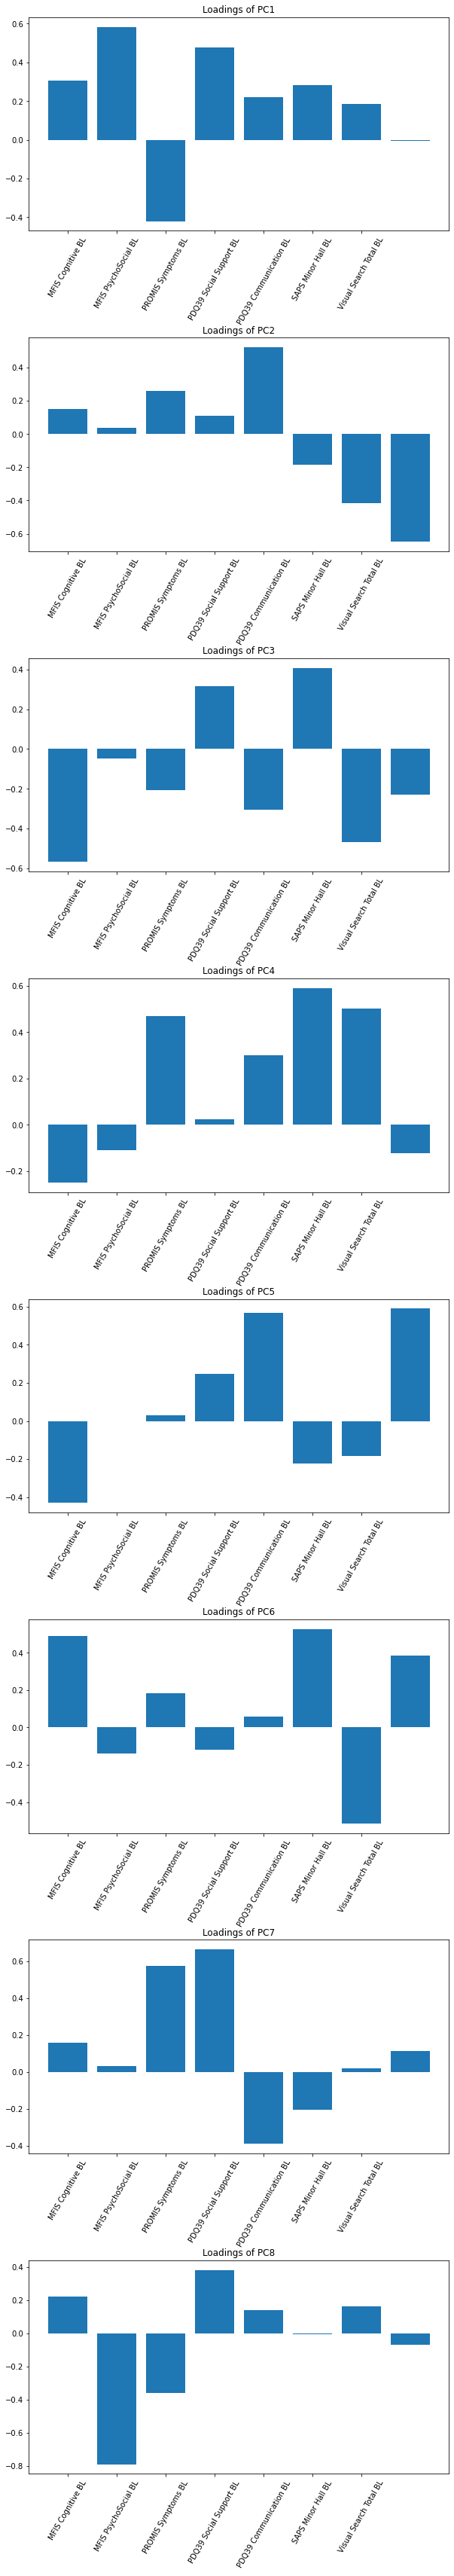

In [ ]:
# Plot of PCs loadings

# Set quantities that are required for the barplot
bars = loadings.index.tolist()
x_pos = np.arange(len(bars))

fig, axs = plt.subplots(loadings.shape[1], figsize=(10,60))
fig.subplots_adjust(hspace=0.5)

# Set the ticks and ticklabels for all axes
plt.setp(axs, xticks=np.arange(7), xticklabels=bars)

# Iterate over the PCs
for i in range(axs.shape[0]):
  # Current heights of the bars
  height = np.asarray(loadings.iloc[:,i])

  # Create barplot
  axs[i].bar(x_pos, height)
  axs[i].set_title("".join(["Loadings of PC",str(i+1)]))
  # Rotate axis
  axs[i].tick_params(axis='x', rotation=60)

plt.show()

A clear interpretation is not viable in this case...

### 3. Permutation Importance
Idea: *The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.*

This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

**N.B.** Model *agnostic* procedure; Therefore we apply it using different classification algorthm such as:
- Linear Discriminant Analysis;
- Support Vector Machine;
- Lasso Logistic Regression;
- Ridge Logistic Regression;
- Gradient Boosting;
- Random Forest.

**N.B.** *Warning*: Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

In [ ]:
# Installing the most recent version of skopt directly from Github
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/scikit-optimize/scikit-optimize.git to /tmp/pip-req-build-krrolu0l
  Running command git clone -q https://github.com/scikit-optimize/scikit-optimize.git /tmp/pip-req-build-krrolu0l
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
  Created wheel for scikit-optimize: filename=scikit_optimize-0.9.0-py2.py3-none-any.whl size=100268 sha256=cf7864494c73d8601d3bfe2d601c537c0de08b770065b64b9172e3fb1b4ed4c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-d4hihb3z/wheels/d6/9e/e3/8818f5597f06caa60393811f8aa57eb87b8565d772046d1b72
Successfully built scikit-optimize


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#### 3.1. Hyperparameters Tuning
Tune the hyperparameters of all the models employed to compute feature importance using a *Bayesian Optimization* approach

In [ ]:
# SUPPORT VECTOR MACHINE
opt = BayesSearchCV(
    SVC(),
    {
      'C': (1e-6, 1e+6, 'log-uniform'),
      'gamma': (1e-6, 1e+1, 'log-uniform'),
      'degree': (1, 8),
      'kernel': ['linear', 'poly', 'rbf']
    },
    n_iter=32, cv=3, n_points=4, n_jobs=-1)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

svm_best = opt.best_params_
print(svm_best)

val. score: 0.6262626262626263
OrderedDict([('C', 622033.8896327673), ('degree', 4), ('gamma', 0.019863513689865126), ('kernel', 'poly')])


In [ ]:
# LASSO LOGISTIC REGRESSION
opt = BayesSearchCV(
    LogisticRegression(penalty="l1", solver="saga", max_iter=10000),
    {
      'C': Real(1e-6, 1e+6, 'log-uniform')
    },
    n_iter=32, cv=3, n_points=4, n_jobs=-1)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

lasso_best = opt.best_params_
print(lasso_best)

val. score: 0.6868686868686869
OrderedDict([('C', 0.5150307230990253)])


In [ ]:
# RIDGE LOGISTIC REGRESSION
opt = BayesSearchCV(
    LogisticRegression(penalty="l2", max_iter=10000),
    {
      'C': Real(1e-6, 1e+6, 'log-uniform')
    },
    n_iter=32,
    cv=3
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

ridge_best = opt.best_params_
print(ridge_best)

val. score: 0.6262626262626263
OrderedDict([('C', 0.01690593728431014)])


In [ ]:
# ELASTICNET LOGISTIC REGRESSION
opt = BayesSearchCV(
    LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000),
    {
      'C': (1e-6, 1e+6, 'log-uniform'),
      'l1_ratio': Real(0,1)
    },
    n_iter=32,
    cv=3
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

elastic_best = opt.best_params_
print(elastic_best)

val. score: 0.5707070707070707
OrderedDict([('C', 1.9223229850829195e-06), ('l1_ratio', 0.17752790132720478)])


In [ ]:
# LINEAR DISCRIMINANT ANALYSIS
opt = BayesSearchCV(
    LinearDiscriminantAnalysis(solver='lsqr'),
    {
      'shrinkage': Real(0,1)
    },
    n_iter=32,
    cv=3
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

lda_best = opt.best_params_
print(lda_best)

val. score: 0.5984848484848485
OrderedDict([('shrinkage', 0.05488624980510283)])


In [ ]:
# RANDOM FOREST

# Set parameters space
# Number of trees in random forest
n_estimators = Integer(50,500)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [x for x in np.linspace(2,16,15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = Integer(2,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = Integer(1,4)

# Create the grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

opt = BayesSearchCV(
    RandomForestClassifier(),
    param_grid,
    n_iter=32,
    cv=3
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

rf_best = opt.best_params_
print(rf_best)

val. score: 0.6262626262626262
OrderedDict([('max_depth', 11.0), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('min_samples_split', 4), ('n_estimators', 192)])


In [ ]:
# from sklearn.metrics import confusion_matrix

# X_train, X_val, y_train, y_val = train_test_split(X, y)

# clf = RandomForestClassifier(**rf_best)

# clf.fit(X_train, y_train)
# preds = clf.predict(X_val)
# cm = confusion_matrix(y_val, preds)

In [ ]:
# GRADIENT BOOSTING

# Set the hyperparameters space

# Learning Rate
learning_rates = Real(0.01, 0.5)
# Number of trees
n_estimators = Integer(10,200)
# Max depth of a tree
max_depth = [x for x in np.linspace(2,16,15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = Integer(2,5)
# Minimum number of samples required at each leaf node
min_samples_leaf = Integer(1,4)
# Max features
max_features = ['auto', 'sqrt', 'log2']

# Create the grid
param_grid = {'learning_rate': learning_rates,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}


opt = BayesSearchCV(
    GradientBoostingClassifier(),
    param_grid,
    n_iter=32,
    cv=3
)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)

gb_best = opt.best_params_
print(gb_best)

val. score: 0.6818181818181818
OrderedDict([('learning_rate', 0.2645346690990772), ('max_depth', 2.0), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 3), ('n_estimators', 142)])


#### 3.2. *Feature Importance* using the Permutation schema

**N.B.** 
1. As this approach involves random procedures, we repeat it and take as result the average of the partial results.
2. Permutation Importance method is usually applied on a validation set of data.
In this case we consider a K-fold CV of our data. Then, for each split, the model is trained of the K-1 folds and permutation importance is applied to the remaining one. Given the size of the dataset we cannot do more than 3-fold CV.
3. We use as hyperparameters for the considered models the one computed in the previous section.

In [ ]:
from progressbar import ProgressBar

def PermutationImportanceCV(X, y, model, best_params, cv_splits=3, cv_repeats=5):
  # Define a k-fold CV schema
  rskf = RepeatedKFold(n_splits=cv_splits, 
                       n_repeats=cv_repeats, 
                       random_state=1234)

  # Array to store feature importance
  feat_imp = np.zeros(len(X.columns))
  feat_imp_sq = np.zeros(len(X.columns))
  accuracy = 0

  # Iterate over the CV partitions
  pbar = ProgressBar()
  for train_index, valid_index in pbar(rskf.split(X, y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # # Perform hyperparameters tuning
    # opt = BayesSearchCV(model,
    #                     param_grid,
    #                     n_iter=32,
    #                     cv=3,
    #                     n_points=4,
    #                     n_jobs=-1)
    # opt.fit(X_train, y_train)
    # best_params = opt.best_params_

    # Compute Permutation importance
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Compute the accuracy on the valid set 
    y_pred = model.predict(X_valid)
    accuracy += accuracy_score(y_true=y_valid, y_pred=y_pred, normalize=True)

    res = permutation_importance(model, X_valid, y_valid, n_repeats=5, 
                                 random_state=1234, n_jobs=-1)
    feat_imp += res.importances_mean
    feat_imp_sq += res.importances_mean**2
  
  feat_imp_mean = feat_imp / (cv_repeats * cv_splits)
  feat_imp_std = np.sqrt(feat_imp_sq / (cv_repeats * cv_splits - 1))
  accuracy = accuracy / (cv_repeats * cv_splits)

  return {'mean': feat_imp_mean, 'std': feat_imp_std, 'accuracy': accuracy}

Compute Permutation Feature Importance for all the selected models.

In [ ]:
# Define the estimators togheter with grid for hyperparameters:
classifiers = [
    {'name': 'SVM', 
     'model': SVC(),
     'opt_param': svm_best},

    {'name': 'Random Forest', 
     'model': RandomForestClassifier(),
     'opt_param': rf_best},

    {'name': 'Gradient Boosting', 
     'model': GradientBoostingClassifier(),
     'opt_param': gb_best},

    {'name': 'Lasso', 
     'model': LogisticRegression(penalty='l1', solver="saga", max_iter=10000),
     'opt_param': lasso_best},

    {'name': 'Ridge', 
     'model': LogisticRegression(penalty='l2', max_iter=10000),
     'opt_param': ridge_best}, 
    
    {'name': 'ElasticNet', 
     'model': LogisticRegression(penalty="elasticnet", solver="saga", max_iter=10000),
     'opt_param': elastic_best}, 

    {'name': 'Linear Discriminant Analysis', 
     'model': LinearDiscriminantAnalysis(solver='lsqr'),
     'opt_param': lda_best}]

In [ ]:
# Compute Permutation Importance for all the classifiers
feat_importances = []

np.random.RandomState(seed=1234)

for item in classifiers:
  # Identify the current values
  curr_name = item['name']
  curr_model = item['model']
  curr_best_params = item['opt_param']
  # with warnings.catch_warnings():
  #     warnings.simplefilter("ignore")
  new_feat_imp = PermutationImportanceCV(X_red, y, 
                                          curr_model, 
                                          curr_best_params, 
                                          cv_repeats=20)
  
  # Create a new dictionary with the values of feature importance
  new_dict = {'name': curr_name,
              'mean': new_feat_imp['mean'],
              'std': new_feat_imp['std'],
              'accuracy': new_feat_imp['accuracy']}
  feat_importances.append(new_dict)

| |             #                                    | 59 Elapsed Time: 0:00:08
| | #                                                | 59 Elapsed Time: 0:01:50
| |                         #                        | 59 Elapsed Time: 0:00:12
| |                                        #         | 59 Elapsed Time: 0:00:05
| |                                       #          | 59 Elapsed Time: 0:00:06
| |                             #                    | 59 Elapsed Time: 0:00:07
| |                   #                              | 59 Elapsed Time: 0:00:08


In [ ]:
for item in feat_importances:
  print(item['name'] + ':')
  print('Accuracy:', item['accuracy'])
  sort = (-item['mean']).argsort()
  for i in range(X_red.shape[1]):
    print(X_red.columns[sort[i]], item['mean'][sort[i]]*100, 
          item['std'][sort[i]]*100)
    
  print('\n')

SVM:
Accuracy: 0.5929292929292931
Visual Search Total BL 7.505050505050503 12.022323893865074
SAPS Minor Hall BL 3.8030303030303045 7.724074587182236
PROMIS Symptoms BL 2.6843434343434343 9.276084436803941
Benton Major Rot BL 2.484848484848485 8.250487007876933
MFIS Cognitive BL 1.4848484848484853 7.493700435511117
MFIS PsychoSocial BL 1.101010101010101 7.448128822937123
PDQ39 Social Support BL 0.3459595959595959 5.193303124977514
 PDQ39 Communication BL -0.09090909090909076 7.503870536336614


Random Forest:
Accuracy: 0.6247474747474748
PDQ39 Social Support BL 4.133838383838382 7.030146952910353
Visual Search Total BL 1.8989898989898988 8.586412461867175
 PDQ39 Communication BL 1.164141414141414 6.052929138879228
SAPS Minor Hall BL 1.0277777777777775 6.190348556136022
MFIS PsychoSocial BL 0.5101010101010096 6.941334847204826
PROMIS Symptoms BL -0.2626262626262631 7.046648727155183
MFIS Cognitive BL -0.7171717171717173 5.877895611073739
Benton Major Rot BL -0.73989898989899 4.125950854

Lasso, Ridge and ElasticNet give strange results...

A potential drawback of the Permutation Importance technique is that it tends to provide not so consistent results when there is *multicollinearity* among features. (Indeed, in this case, when we permute one feature the drop on the model performance is mitigated by the presence of one or more correlated features).

Therefore, we should carefully check collinearity between features and potentially cluster features which are too much correlated. Then during the permutation approach features belonging to the same cluster are permuted together.

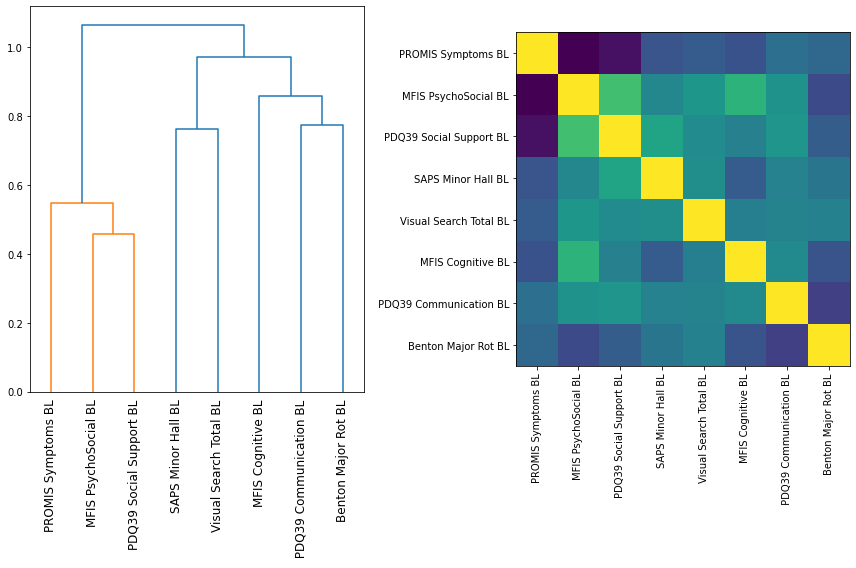

In [ ]:
# Group features avoiding multi-collinearity problem
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_red).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)

dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, 
                              labels=X_red.columns.tolist(), 
                              ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.6, criterion="distance")
cluster_ids
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(X_red.columns[idx])

In [ ]:
# Example of selected features for permutation importance
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features

['MFIS Cognitive BL',
 'MFIS PsychoSocial BL',
 ' PDQ39 Communication BL',
 'SAPS Minor Hall BL',
 'Visual Search Total BL',
 'Benton Major Rot BL']

#### 3.3. Aggreagate feature importance rankings

Make rankings

In [ ]:
feat_rankings = []
for item in feat_importances:
  new_dict = {}
  new_dict['name'] = item['name']
  new_dict['accuracy'] = item['accuracy']
  idxs_ranking = (-item['mean']).argsort()
  new_dict['rank'] = dict(zip(idxs_ranking, np.arange(1,len(item['mean'])+1)))
  feat_rankings.append(new_dict)

Aggregate rankings

In [ ]:
final_ranking = np.zeros(X_red.shape[1])
for rk in feat_rankings:
  temp_ranking = np.zeros(X_red.shape[1])
  for key in rk['rank']:
    temp_ranking[key] = rk['rank'][key]
  final_ranking += temp_ranking*rk['accuracy']
final_ranking

final_ranking = final_ranking.argsort()
[X_red.columns.tolist()[i] for i in final_ranking]

['PDQ39 Social Support BL',
 'PROMIS Symptoms BL',
 'MFIS PsychoSocial BL',
 'Visual Search Total BL',
 'SAPS Minor Hall BL',
 'Benton Major Rot BL',
 'MFIS Cognitive BL',
 ' PDQ39 Communication BL']

## Classification

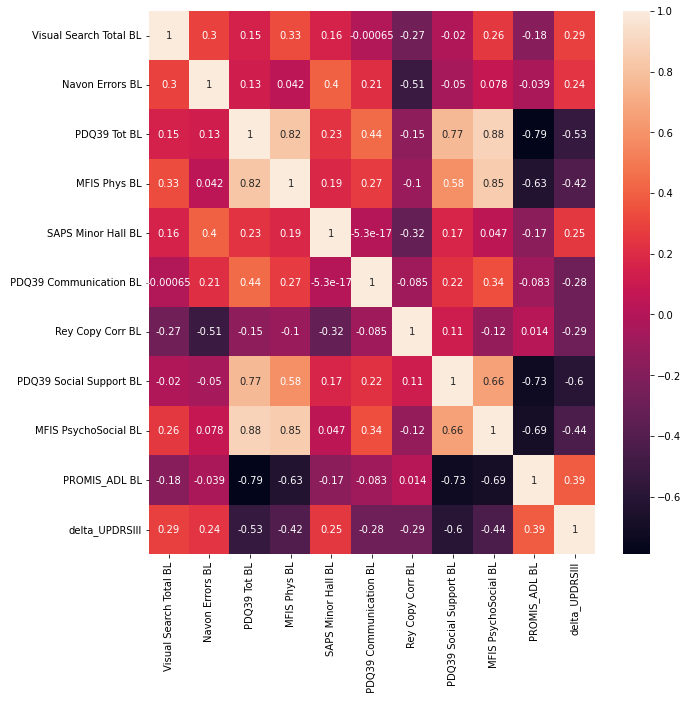

In [ ]:
X_complete = X_train_red.copy()
X_complete["delta_UPDRSIII"] = -data_pred["delta_UPDRSIII"]
cor_mat = X_complete.corr()

plt.figure(figsize=(10,10))
sns.heatmap(cor_mat, annot=True)

Prepare target variable for classification.

Cut-off for labels: median of *delta_UPDRSIII* (-6)

Divide records in 2 classes:
- *BETTER* -> 16 records
- *WORSE|SAME* -> 12 records



In [ ]:
cut_off = -6
y_train_cat = []
for i,val in enumerate(y_train):
  if val <= cut_off:
    y_train_cat.append("BETTER")
  elif val > cut_off:
    y_train_cat.append("SAME|WORSE")

y_train_cat = np.asarray(y_train_cat)
print(y_train_cat)
print(len(np.where(y_train_cat=='BETTER')[0]),
      len(np.where(y_train_cat=="SAME|WORSE")[0]))

y_test_cat = []
for i,val in enumerate(y_test):
  if val <= cut_off:
    y_test_cat.append("BETTER")
  elif val > cut_off:
    y_test_cat.append("SAME|WORSE")

y_test_cat = np.asarray(y_test_cat)

['SAME|WORSE' 'BETTER' 'SAME|WORSE' 'BETTER' 'BETTER' 'BETTER'
 'SAME|WORSE' 'BETTER' 'SAME|WORSE' 'BETTER' 'BETTER' 'SAME|WORSE'
 'BETTER' 'BETTER' 'SAME|WORSE' 'SAME|WORSE' 'BETTER' 'BETTER' 'BETTER'
 'SAME|WORSE' 'BETTER' 'SAME|WORSE' 'SAME|WORSE' 'SAME|WORSE' 'BETTER'
 'SAME|WORSE' 'BETTER' 'BETTER']
16 12


In [ ]:
from sklearn.feature_selection import mutual_info_classif

np.random.RandomState(seed=1234)
n_iter = 20
mi_class = np.zeros(10)
for i in range(n_iter):
  mi_class_temp = mutual_info_classif(X_train_red, y_train_cat)
  mi_class_temp /= np.max(mi_class_temp)
  mi_class += mi_class_temp

mi_class /= n_iter
mi_class = pd.DataFrame(mi_class.reshape(1,-1), index=["delta_UPDRSIII"], 
                        columns=X_train_red.columns)

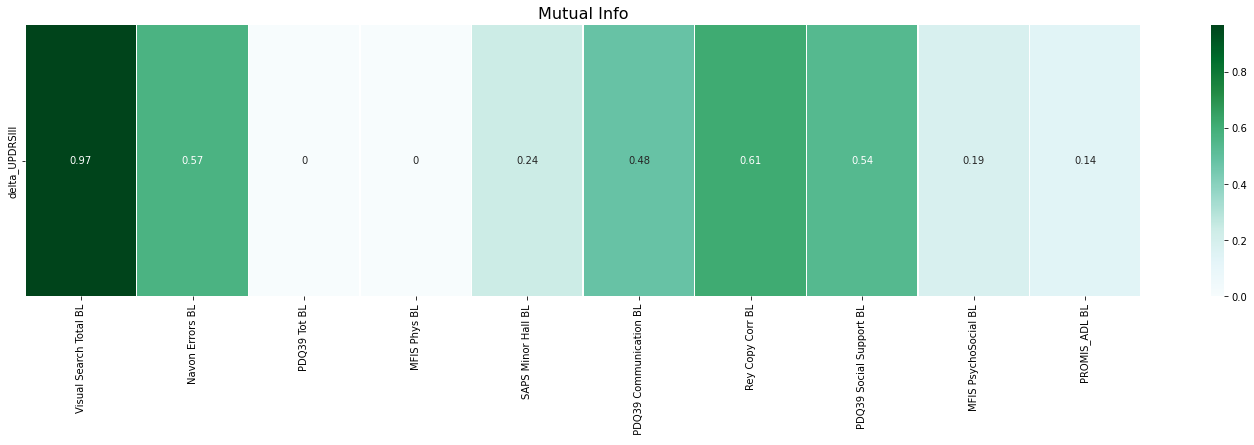

In [ ]:
plt.figure(figsize=(25,5))
sns.heatmap(mi_class, linewidths=.5, cmap="BuGn", annot=True)
plt.title("Mutual Info", fontsize=16)
plt.show()

PCA with the selected variables

Naive-Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train_cat).predict(X_test)
for i in range(len(y_pred)):
  print(y_pred[i], y_test_cat[i])

SAME|WORSE BETTER
SAME|WORSE BETTER
SAME|WORSE SAME|WORSE
BETTER BETTER
BETTER SAME|WORSE
SAME|WORSE BETTER
SAME|WORSE SAME|WORSE
